## 1 D regresstion

In [51]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) 
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(129, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class cnp(nn.Module):
    def __init__(self):
        super(cnp, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.stack([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 1)], dim=1)
        output = self.decoder(decoder_input)
        return output



In [3]:
model = cnp()


In [4]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Simple Sine Wave

In [5]:
def generate_data(num_samples):
    x = np.random.uniform(-5, 5, num_samples)
    y = np.sin(x)  
    plt.scatter(x, y)
    return x, y



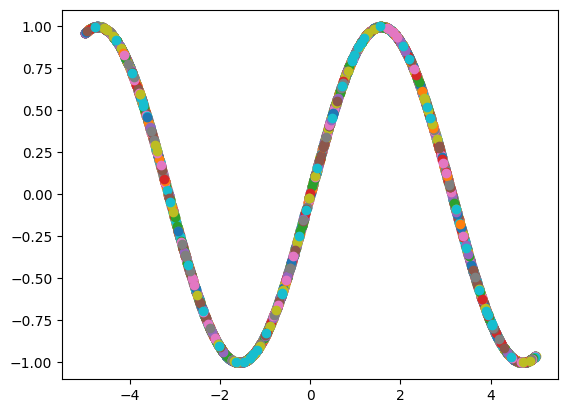

In [6]:
training_data =[generate_data(42) for i in range(100)]

In [7]:
num_epochs = 1000
for epoch in range(num_epochs):
    context=np.random.choice(42, 10, replace=False)
    target=np.random.choice(42, 32, replace=False)
    train_set=np.random.randint(0, 99)


    target_x=training_data[train_set][0][target]
    target_y=training_data[train_set][1][target]
    context_x=training_data[train_set][0][context]
    context_y=training_data[train_set][1][context]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32)

    
    model.train()
    optimizer.zero_grad()
    predictions = model(context_x, context_y, target_x)
    loss = criterion(predictions, target_y.view(-1, 1))
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/1000], Loss: 0.5227
Epoch [2/1000], Loss: 0.5894
Epoch [3/1000], Loss: 0.4845
Epoch [4/1000], Loss: 0.5158
Epoch [5/1000], Loss: 0.4957
Epoch [6/1000], Loss: 0.3443
Epoch [7/1000], Loss: 0.4561
Epoch [8/1000], Loss: 0.5926
Epoch [9/1000], Loss: 0.4966
Epoch [10/1000], Loss: 0.4952
Epoch [11/1000], Loss: 0.3750
Epoch [12/1000], Loss: 0.4952
Epoch [13/1000], Loss: 0.3608
Epoch [14/1000], Loss: 0.3827
Epoch [15/1000], Loss: 0.4202
Epoch [16/1000], Loss: 0.3581
Epoch [17/1000], Loss: 0.3477
Epoch [18/1000], Loss: 0.3437
Epoch [19/1000], Loss: 0.3259
Epoch [20/1000], Loss: 0.3699
Epoch [21/1000], Loss: 0.2178
Epoch [22/1000], Loss: 0.1562
Epoch [23/1000], Loss: 0.1985
Epoch [24/1000], Loss: 0.1256
Epoch [25/1000], Loss: 0.2329
Epoch [26/1000], Loss: 0.1983
Epoch [27/1000], Loss: 0.1564
Epoch [28/1000], Loss: 0.0964
Epoch [29/1000], Loss: 0.0770
Epoch [30/1000], Loss: 0.1478
Epoch [31/1000], Loss: 0.0971
Epoch [32/1000], Loss: 0.0892
Epoch [33/1000], Loss: 0.1149
Epoch [34/1000], Lo

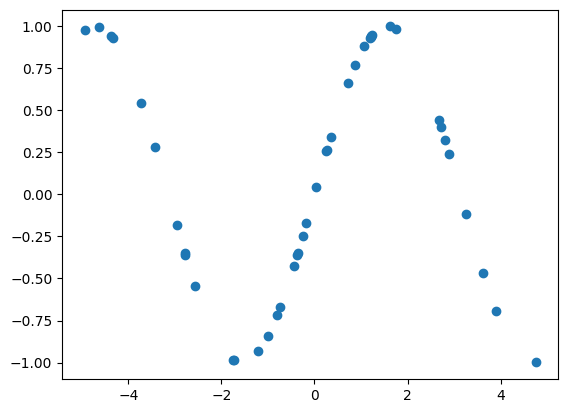

In [8]:
test_data = generate_data(42)

In [9]:
context=np.random.choice(42, 10, replace=False)
target=np.random.choice(42, 32, replace=False)


target_x=test_data[0][target]
target_y=test_data[1][target]
context_x=test_data[0][context]
context_y=test_data[1][context]


context_x = torch.tensor(context_x, dtype=torch.float32)
context_y = torch.tensor(context_y, dtype=torch.float32)
target_x = torch.tensor(target_x, dtype=torch.float32)
target_y = torch.tensor(target_y, dtype=torch.float32)

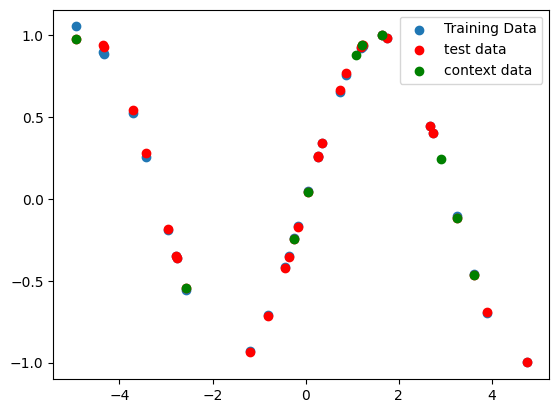

In [10]:
predictions = model(context_x, context_y, target_x)
plt.scatter(target_x, predictions.detach().numpy(), label='Training Data')
plt.scatter(target_x, target_y, label="test data", color='r')
plt.scatter(context_x, context_y, label="context data", color='g')
plt.legend()

### Different Amplitude Sine Wave

In [11]:
#create multiple sine waves with different amplitudes and phases

def generate_sin_data(num_samples):
    x=np.linspace(-5, 5, num_samples)
    amplitude= np.random.uniform(1, 5)
    y=amplitude*np.sin(x)
    plt.scatter(x, y, label='Training Data')
    return x, y


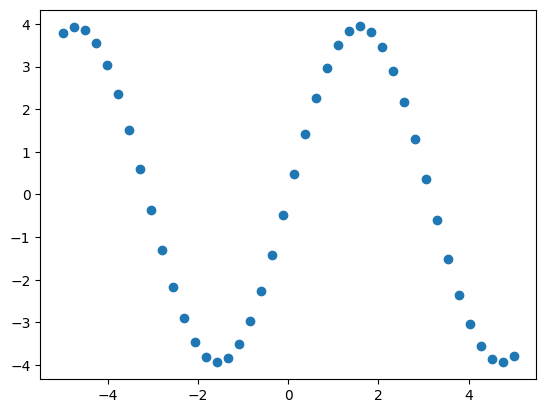

In [12]:
data=generate_sin_data(42)

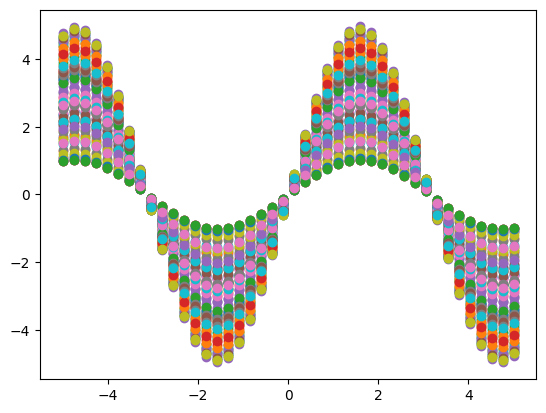

In [13]:
training_data =[generate_sin_data(42) for i in range(100)]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)

        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) 
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(129, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x= F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class cnp_sin(nn.Module):
    def __init__(self):
        super(cnp, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.stack([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 1)], dim=1)
        output = self.decoder(decoder_input)
        return output



In [14]:
model2 = cnp()

In [15]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

100%|██████████| 3000/3000 [00:02<00:00, 1234.81it/s]


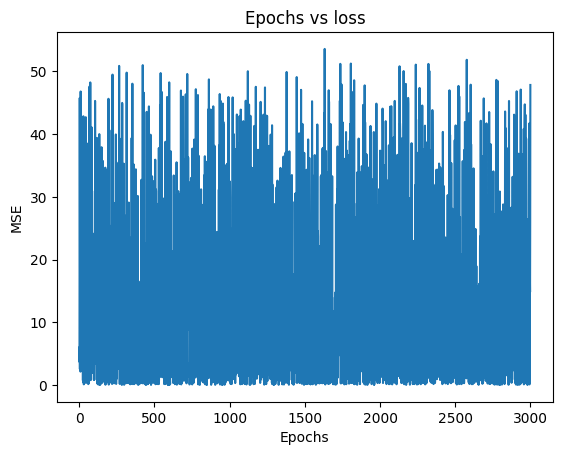

In [53]:
from tqdm import tqdm
losses = []
num_epochs = 3000
for epoch in tqdm(range(num_epochs)):
    context=np.random.choice(42, 10, replace=False)
    target=np.random.choice(42, 32, replace=False)
    train_set=np.random.randint(0, 99)


    target_x=training_data[train_set][0][target]
    target_y=training_data[train_set][1][target]
    context_x=training_data[train_set][0][context]
    context_y=training_data[train_set][1][context]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32)

    model2.train()
    optimizer.zero_grad()
    predictions = model2(context_x, context_y, target_x)
    loss = criterion(predictions, target_y.view(-1, 1))
    loss.backward()
    optimizer.step()
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    losses.append(loss.item())

plt.plot(np.arange(1, num_epochs+1), losses)
plt.title("Epochs vs loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

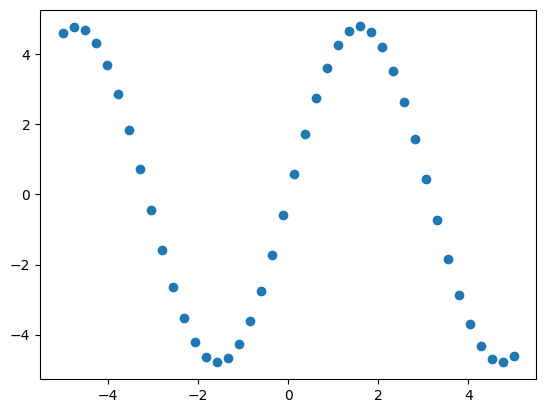

In [17]:
test_data=generate_sin_data(42)

In [18]:
context=np.random.choice(42, 10, replace=False)
target=np.random.choice(42, 32, replace=False)


target_x=test_data[0][target]
target_y=test_data[1][target]
context_x=test_data[0][context]
context_y=test_data[1][context]


context_x = torch.tensor(context_x, dtype=torch.float32)
context_y = torch.tensor(context_y, dtype=torch.float32)
target_x = torch.tensor(target_x, dtype=torch.float32)
target_y = torch.tensor(target_y, dtype=torch.float32)

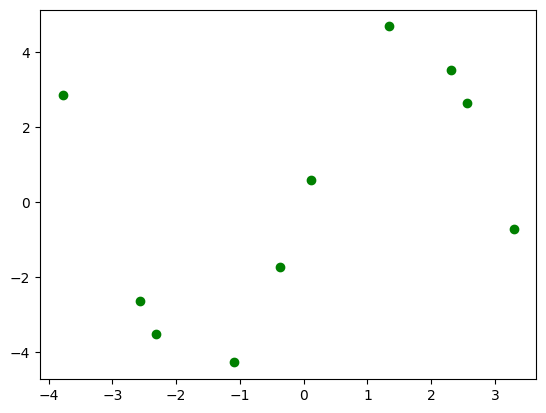

In [19]:
plt.scatter(context_x, context_y, label="context data", color='g')


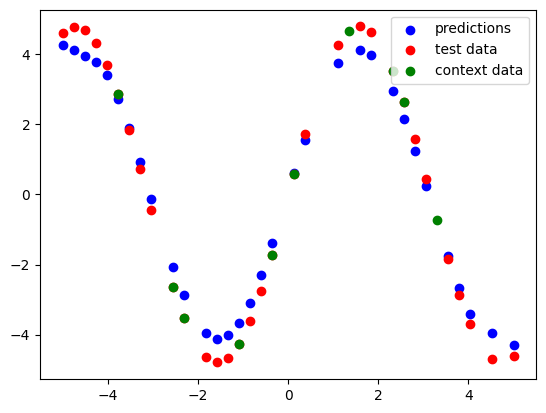

In [20]:
predictions = model2(context_x, context_y, target_x)
plt.scatter(target_x, predictions.detach().numpy(), label='predictions', color='b')
plt.scatter(target_x, target_y, label="test data", color='r')
plt.scatter(context_x, context_y, label="context data", color='g')
plt.legend()

### Different Amplitude and Phase Sine Wave

In [21]:
#create multiple sine waves with different amplitudes and phases

def generate_sin_phase_data(num_samples):
    x=np.linspace(-5, 5, num_samples)
    amplitude= np.random.uniform(1, 5)
    phase=np.random.uniform(0, np.pi)
    y=amplitude*np.sin(x+phase)
    plt.scatter(x, y, label='Training Data')
    return x, y


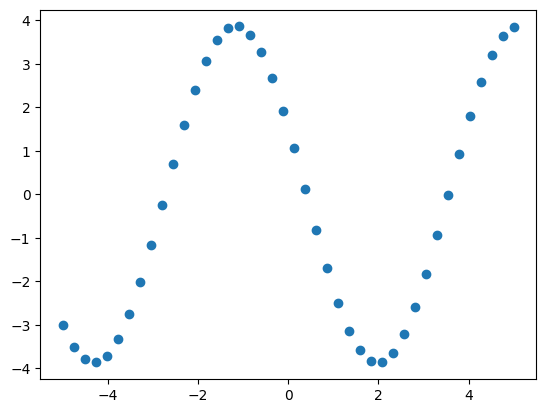

In [22]:
data=generate_sin_phase_data(42)

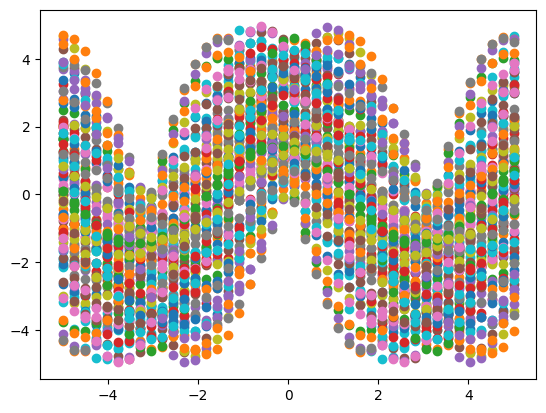

In [23]:
training_data =[generate_sin_phase_data(42) for i in range(100)]

In [24]:
model3 = cnp()

In [25]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

In [26]:
num_epochs = 3000
for epoch in range(num_epochs):
    context=np.random.choice(42, 10, replace=False)
    target=np.random.choice(42, 32, replace=False)
    train_set=np.random.randint(0, 99)


    target_x=training_data[train_set][0][target]
    target_y=training_data[train_set][1][target]
    context_x=training_data[train_set][0][context]
    context_y=training_data[train_set][1][context]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32)

    model3.train()
    optimizer.zero_grad()
    predictions = model3(context_x, context_y, target_x)
    loss = criterion(predictions, target_y.view(-1, 1))
    loss.backward()
    optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [1/3000], Loss: 7.1674
Epoch [2/3000], Loss: 2.8236
Epoch [3/3000], Loss: 7.2927
Epoch [4/3000], Loss: 11.1100
Epoch [5/3000], Loss: 6.9208
Epoch [6/3000], Loss: 1.3332
Epoch [7/3000], Loss: 7.0889
Epoch [8/3000], Loss: 4.1927
Epoch [9/3000], Loss: 0.9980
Epoch [10/3000], Loss: 11.8463
Epoch [11/3000], Loss: 5.2248
Epoch [12/3000], Loss: 1.0696
Epoch [13/3000], Loss: 11.6330
Epoch [14/3000], Loss: 4.1702
Epoch [15/3000], Loss: 4.6957
Epoch [16/3000], Loss: 10.9160
Epoch [17/3000], Loss: 9.0082
Epoch [18/3000], Loss: 0.9006
Epoch [19/3000], Loss: 0.6177
Epoch [20/3000], Loss: 2.3625
Epoch [21/3000], Loss: 11.0989
Epoch [22/3000], Loss: 11.0779
Epoch [23/3000], Loss: 7.5982
Epoch [24/3000], Loss: 11.8526
Epoch [25/3000], Loss: 2.5483
Epoch [26/3000], Loss: 12.0422
Epoch [27/3000], Loss: 2.1669
Epoch [28/3000], Loss: 3.3531
Epoch [29/3000], Loss: 0.5734
Epoch [30/3000], Loss: 1.9227
Epoch [31/3000], Loss: 0.6408
Epoch [32/3000], Loss: 2.4813
Epoch [33/3000], Loss: 11.7800
Epoch [34/

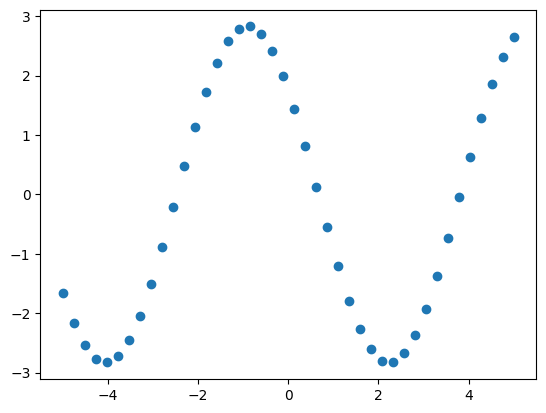

In [27]:
test_data=generate_sin_phase_data(42)

In [28]:
context=np.random.choice(42, 10, replace=False)
target=np.random.choice(42, 32, replace=False)


target_x=test_data[0][target]
target_y=test_data[1][target]
context_x=test_data[0][context]
context_y=test_data[1][context]


context_x = torch.tensor(context_x, dtype=torch.float32)
context_y = torch.tensor(context_y, dtype=torch.float32)
target_x = torch.tensor(target_x, dtype=torch.float32)
target_y = torch.tensor(target_y, dtype=torch.float32)

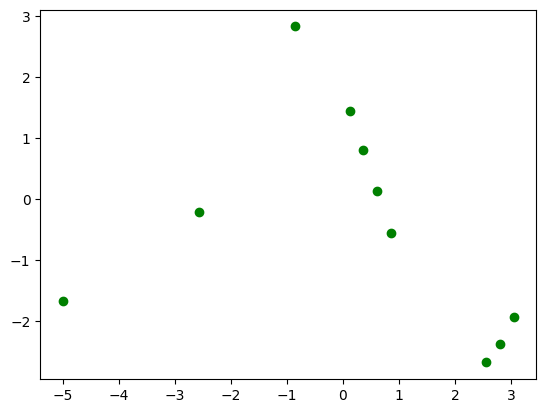

In [29]:
plt.scatter(context_x, context_y, label="context data", color='g')


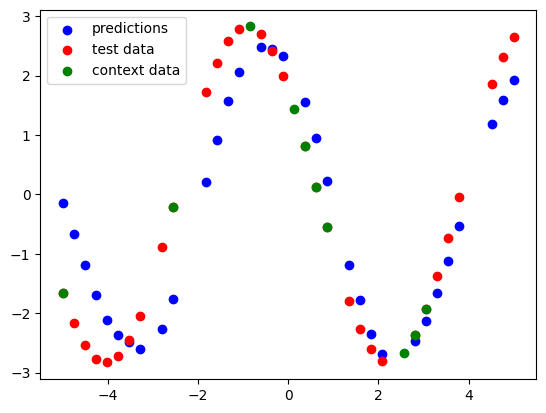

In [30]:
predictions = model3(context_x, context_y, target_x)
plt.scatter(target_x, predictions.detach().numpy(), label='predictions', color='b')
plt.scatter(target_x, target_y, label="test data", color='r')
plt.scatter(context_x, context_y, label="context data", color='g')
plt.legend()

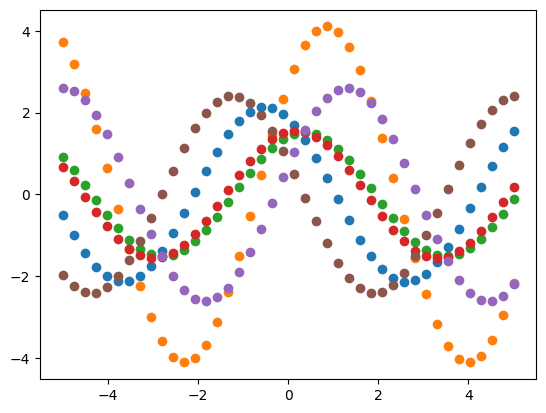

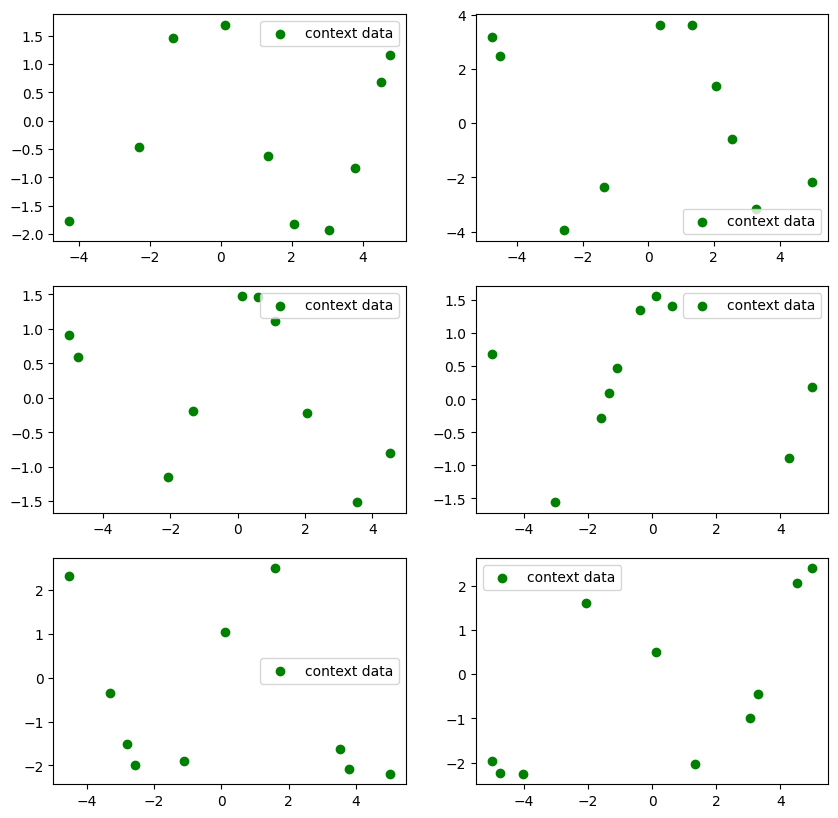

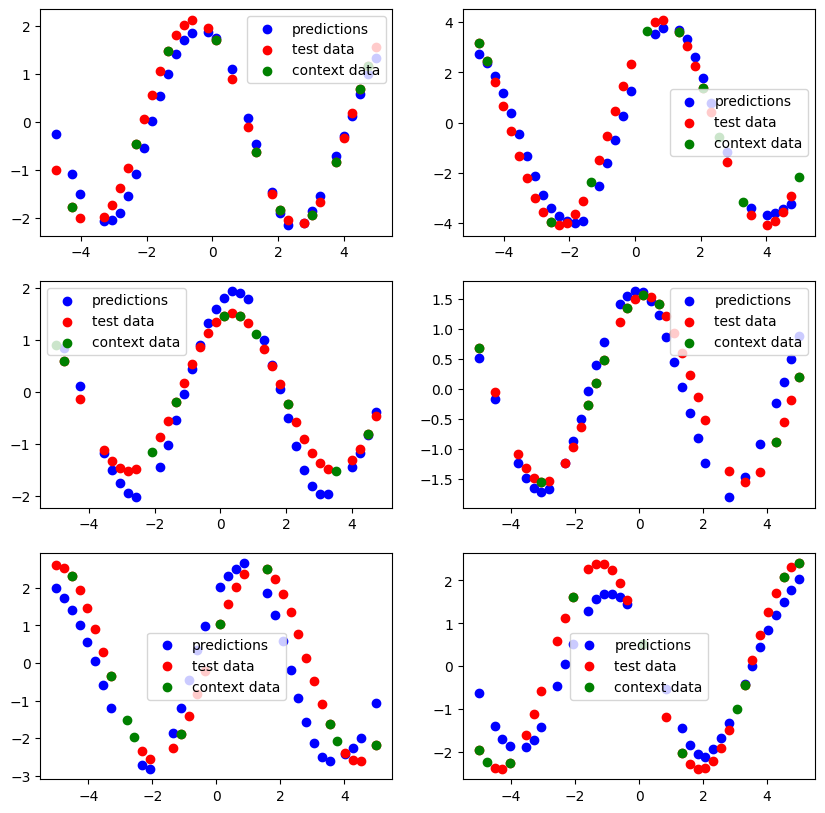

In [31]:
#create 6 subplots with test data and predictions

test_data_sets=[generate_sin_phase_data(42) for i in range(6)]
predictions_sets=[]
fig2, axs2 = plt.subplots(3, 2, figsize=(10, 10))
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(6):
    test_data=test_data_sets[i]
    context=np.random.choice(42, 10, replace=False)
    target=np.random.choice(42, 32, replace=False)


    target_x=test_data[0][target]
    target_y=test_data[1][target]
    context_x=test_data[0][context]
    context_y=test_data[1][context]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32)
    predictions = model3(context_x, context_y, target_x)
    predictions_sets.append(predictions.detach().numpy())

    axs[i//2, i%2].scatter(target_x, predictions.detach().numpy(), label='predictions', color='b')
    axs[i//2, i%2].scatter(target_x, target_y, label="test data", color='r')
    axs[i//2, i%2].scatter(context_x, context_y, label="context data", color='g')
    axs[i//2, i%2].legend()

    axs2[i//2, i%2].scatter(context_x, context_y, label="context data", color='g')
    axs2[i//2, i%2].legend()



In [32]:
#get mnist dataset

In [33]:
from tensorflow.keras.datasets import mnist

In [34]:
(trainx, trainy),( testx, testy) = mnist.load_data()

In [35]:
trainx=trainx/255
trainy=trainy/255
testx=testx/255

In [36]:
#reshape into 1d array

trainx=trainx.reshape(60000, 784)
testx=testx.reshape(10000, 784)


In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 128)

        
    def forward(self, x):
        x = torch.sin(30*self.fc1(x))
        x = torch.sin(30*self.fc2(x))
        x = torch.sin(30*self.fc3(x))
        x = self.fc4(x) 
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(129, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = torch.sin(30* self.fc1(x))
        x = torch.sin(30*self.fc2(x))
        x= torch.sin(30*self.fc3(x))
        x = self.fc4(x)
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class cnp_sin(nn.Module):
    def __init__(self):
        super(cnp_sin, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.stack([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 1)], dim=1)
        output = self.decoder(decoder_input)
        return output



In [93]:
model5=cnp()


In [94]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001)

1 dataset

100%|██████████| 1000/1000 [00:10<00:00, 91.09it/s]


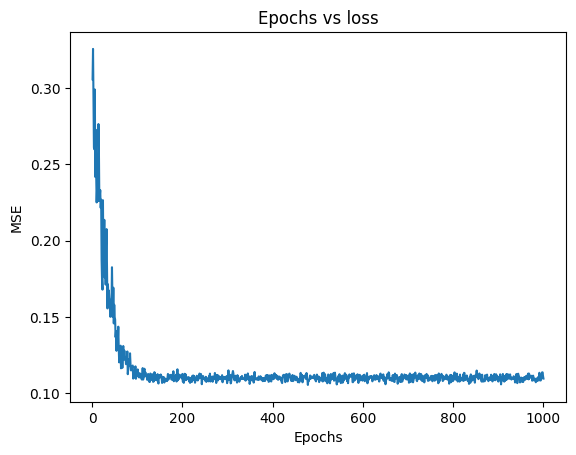

In [95]:
from tqdm import tqdm
losses = []
num_epochs = 1000
for epoch in tqdm(range(num_epochs)):
    image_index=1
    # print(image_index)
    image=trainx[image_index]
    context_x=np.random.choice(784, 396, replace=False)
    target_x=[i for i in range(784)]
    target_y=image
    context_y=image[context_x]


    context_x = torch.tensor(context_x, dtype=torch.float32)
    context_y = torch.tensor(context_y, dtype=torch.float32)
    target_x = torch.tensor(target_x, dtype=torch.float32)
    target_y = torch.tensor(target_y, dtype=torch.float32)

    target_x=target_x/784
    context_x=context_x/784
    

    model5.train()
    optimizer.zero_grad()
    predictions = model5(context_x, context_y, target_x)
    loss = criterion(predictions, target_y.view(-1, 1))
    loss.backward()
    optimizer.step()
    # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    losses.append(loss.item())

plt.plot(np.arange(1, num_epochs+1), losses)
plt.title("Epochs vs loss")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()



In [103]:
image_index=1
image=trainx[image_index]
context_x=np.random.choice(784, , 784,eplace=False)

target_x=[i for i in range(784)]
target_y=image
context_y=trainx[image_index][context_x]

context_x = torch.tensor(context_x, dtype=torch.float32)
context_y = torch.tensor(context_y, dtype=torch.float32)
target_x = torch.tensor(target_x, dtype=torch.float32)
target_y = torch.tensor(target_y, dtype=torch.float32)

target_x=target_x/784
context_x=context_x/784


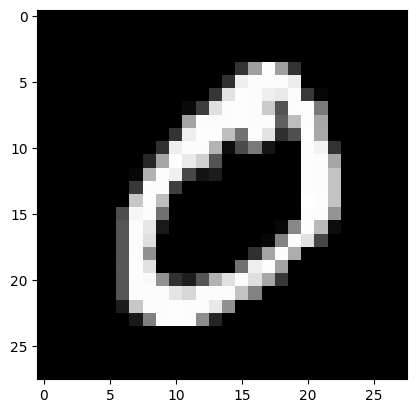

In [104]:
#plot MNIST Image
plt.imshow(image.reshape(28, 28), cmap='gray')

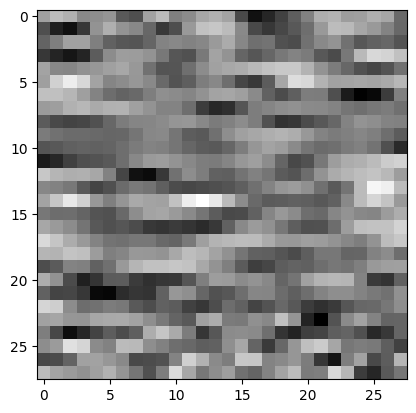

In [105]:
predictions=model5(context_x, context_y, target_x)
plt.imshow(predictions.detach().numpy().reshape(28, 28), cmap='gray')